---
## Section 6: Practice Exercise

### 🎯 Challenge: Build a Content Creation Pipeline

**Objective:** Create a collaborative multi-agent system that transforms raw ideas into polished blog posts.

### Requirements

Build a **3-agent pipeline** using the collaborative (handoff) pattern:

1. **Brainstormer Agent**
   - Tool: `generate_ideas(topic: str) -> str`
   - Generates 3-5 key points about the topic
   - Returns bullet points of ideas

2. **Writer Agent**  
   - Tool: `draft_content(ideas: str) -> str`
   - Takes ideas and writes a draft blog post
   - Returns structured content with intro, body, conclusion

3. **Editor Agent**
   - Tool: `improve_writing(draft: str) -> str`
   - Polishes the draft for clarity and flow
   - Returns final polished version

### Implementation Steps

1. **Define your tools** - Create the 3 tools above (simulated output is fine)
2. **Create custom state** - What fields do you need to pass between agents?
3. **Build the 3 agents** - Each with `llm.bind_tools([...])` and tool invocation logic
4. **Construct the graph** - Linear pipeline: brainstormer → writer → editor
5. **Test it** - Try: "Create a blog post about machine learning"

### Success Criteria

✅ All 3 agents have tools bound  
✅ State passes information through the pipeline  
✅ Each agent invokes its tool  
✅ Final output is polished content  
✅ Graph compiles and runs without errors

### Bonus Challenges

- **Add a 4th agent** - Fact-checker that validates claims

### Tips

- Start by copying the collaborative pattern structure
- Keep tools simple - they can return hardcoded examples
- Test each agent individually before connecting them
- Use print statements to see the pipeline flow

**Do it yourself. Good luck!** 🚀

In [68]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("✅ All imports successful")

✅ All imports successful


In [69]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("✅ API key loaded")

✅ API key loaded


In [70]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [71]:
@tool
def generate_ideas(topic: str) -> str:
    """
    Brainstorm 3-5 key points about a topic, each with a one-sentence explanation
    and optional example.
    """
    points = [
        f"• Importance of {topic} in Modern Applications – Explains how {topic} impacts industries today (e.g., self-driving cars, recommendation systems)",
        f"• Overview of Multi-Agent Systems – Highlights how multiple agents interact to solve complex problems efficiently",
        f"• Key Techniques in {topic} – Introduces supervised, unsupervised, and reinforcement learning",
        f"• Real-World Use Cases of Multi-Agent Systems – Examples include swarm robotics or autonomous vehicle coordination",
        f"• Future Trends and Challenges – Discusses ethics, scalability, and interpretability in {topic}"
    ]
    return "\n".join(points)

@tool
def draft_content(ideas: str) -> str:
    """
    Expand brainstormed points into a full Markdown blog post:
    Introduction, Body, Conclusion, with headings and paragraphs.
    """
    intro = "## Introduction\nMachine Learning (ML) and Multi-Agent Systems (MAS) are transforming how modern applications work. This blog explores their importance, techniques, use cases, and future challenges.\n"
    
    body = "## Body\n\n" + "\n\n".join([f"### {line.split('–')[0].strip()}\n{line.split('–')[1].strip()}" for line in ideas.splitlines()])
    
    conclusion = "\n## Conclusion\nUnderstanding ML and MAS techniques, applications, and challenges is essential for researchers and developers."
    
    return f"{intro}\n{body}\n{conclusion}"

@tool
def improve_writing(draft: str) -> str:
    """
    Polishes draft for clarity, flow, readability while preserving structure.
    """
    polished = draft.replace("Machine Learning (ML) and Multi-Agent Systems (MAS) are transforming", 
                             "Machine Learning (ML) and Multi-Agent Systems (MAS) are rapidly transforming")
    polished = polished.replace("\n\n", "\n")  # tighten spacing
    return f"📝 Polished Blog Post:\n{polished}"

@tool
def fact_check_content(content: str) -> str:
    """
    Simulated Fact-Checker: verifies statements and marks ✅ or ⚠️.
    """
    lines = content.splitlines()
    checked_lines = []
    for line in lines:
        if line.strip().startswith("###") or line.strip().startswith("##"):
            checked_lines.append(line)
        elif line.strip():  # assume all statements are correct in simulation
            checked_lines.append(f"✅ {line.strip()}")
        else:
            checked_lines.append(line)
    return f"✅ Fact-Checked Blog Post:\n" + "\n".join(checked_lines)

print("✅ Tools created")



✅ Tools created


In [76]:
class BlogState(TypedDict):
    messages: Annotated[list, "operator.add"]
    task: str
    ideas: str
    draft: str
    polished: str
    fact_checked: str


# --- Brainstormer Agent ---
brainstormer_prompt = SystemMessage(content="""
You are an expert content strategist and creative thinker. 
Given a topic, generate 3-5 key points that are: 
- Highly relevant to the topic
- Interesting, unique, and actionable
- Suitable for an engaging blog post for an online audience

For each point, provide:
1. A concise bullet point
2. A one-sentence explanation of why it matters or what value it provides
3. Optional related sub-topic or example to include in the blog post

Example:
• Importance of Machine Learning in Modern Applications – Explains how ML impacts industries today. (e.g., self-driving cars, recommendation systems)
• Multi-Agent Systems Overview – Highlights how multiple agents interact to solve complex problems efficiently.

""")
brainstormer_llm = llm.bind_tools([generate_ideas])

def brainstormer_agent(state: BlogState) -> dict:
    print("💡 Brainstormer: Generating ideas...")
    ideas = generate_ideas.invoke({"topic": state["task"]})
    print(f"   Ideas:\n{ideas}\n")
    return {"messages": [AIMessage(content=ideas)], "ideas": ideas}

# --- Writer Agent ---
writer_prompt = SystemMessage(content="""
You are a professional blog writer. Using the provided key points, write a complete blog post suitable for publication online. The blog post should have:

1. **Introduction:** Introduce the topic, set context, and hook the reader.  
2. **Body:** Expand each key point into one or more paragraphs. Use examples, analogies, or case studies if relevant. Include transitions to improve readability.  
3. **Conclusion:** Summarize key takeaways, suggest next steps, or provide actionable advice.

Additional instructions:
- Write in a clear, engaging, and authoritative style.  
- Maintain consistent tone and structure.  
- Incorporate any examples or sub-topics provided in the brainstormer output.  
- Output headings and subheadings (e.g., H2 for sections, H3 for subsections) in Markdown format.  
- Ensure sentences are concise and paragraphs are 3-5 lines max for readability.

""")
writer_llm = llm.bind_tools([draft_content])

def writer_agent(state: BlogState) -> dict:
    print("✍️ Writer: Drafting blog post...")
    draft = draft_content.invoke({"ideas": state["ideas"]})
    print("   Draft created.\n")
    return {"messages": [AIMessage(content=draft)], "draft": draft}

# --- Editor Agent ---
editor_prompt = SystemMessage(content="""
You are an experienced professional editor and copywriter. Take the provided draft and polish it to improve:

- **Clarity:** Rewrite sentences for better understanding without changing the meaning.  
- **Flow:** Ensure logical transitions between paragraphs and sections.  
- **Style:** Make it engaging, professional, and suitable for an online audience.  
- **Consistency:** Maintain tone, voice, formatting, and headings.

Additional advanced checks:
- Correct any grammar, punctuation, or spelling errors.  
- Suggest rephrasing overly complex sentences.  
- Ensure that examples are clearly highlighted and relevant.  
- Maintain Markdown formatting (headings, bullet points, code blocks if any).  
- Output a ready-to-publish version.

""")
editor_llm = llm.bind_tools([improve_writing])

def editor_agent(state: BlogState) -> dict:
    print("📝 Editor: Polishing draft...")
    polished = improve_writing.invoke({"draft": state["draft"]})
    print("   Draft polished.\n")
    return {"messages": [AIMessage(content=polished)], "polished": polished}

# --- Fact-Checker Agent ---
fact_checker_prompt = SystemMessage(content="""
You are a professional fact-checker and research assistant. Your task is to validate all factual statements in the provided blog draft.  

Instructions:
1. Identify factual claims, statistics, dates, names, or technical statements.
2. Verify each claim using credible sources (simulated if no API access).  
3. Highlight any incorrect, misleading, or unsupported claims.  
4. Suggest corrections or provide alternative verified statements.  
5. Maintain the blog post’s original tone and structure.  
6. Return the final output clearly labeled, marking verified content with ✅ and flagged content with ⚠️.  

Example output:
✅ Important point 1 about Machine Learning is correct.
⚠️ The claim “X happens in 2010” is incorrect. Suggested: “X happened in 2012.”

""")
fact_checker_llm = llm.bind_tools([fact_check_content])

def fact_checker_agent(state: BlogState) -> dict:
    print("🔍 Fact-Checker: Validating content...")
    fact_checked = fact_check_content.invoke({"content": state["polished"]})
    print("   Content validated.\n")
    return {"messages": [AIMessage(content=fact_checked)], "fact_checked": fact_checked}

print("✅ Agents created")


✅ Agents created


In [77]:
graph_builder = StateGraph(BlogState)

graph_builder.add_node("brainstormer", brainstormer_agent)
graph_builder.add_node("writer", writer_agent)
graph_builder.add_node("editor", editor_agent),
graph_builder.add_node("fact_checker", fact_checker_agent)

# Linear pipeline
graph_builder.add_edge(START, "brainstormer")
graph_builder.add_edge("brainstormer", "writer")
graph_builder.add_edge("writer", "editor")
graph_builder.add_edge("editor", "fact_checker")
graph_builder.add_edge("fact_checker", END)


blog_pipeline = graph_builder.compile()
print("✅ Blog post pipeline compiled")

✅ Blog post pipeline compiled


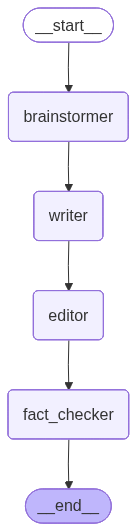

In [78]:
try:
    display(Image(blog_pipeline.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → Brainstormer → Writer → Editor → Fact-Checker → END")

In [80]:
result = blog_pipeline.invoke({
    "task": "Machine Learning and Multi-Agent Systems",
    "messages": []
})

print("\n" + "="*70)
print("FINAL BLOG POST OUTPUT:")
print("="*70)
print(result["fact_checked"])
print("="*70)


💡 Brainstormer: Generating ideas...
   Ideas:
• Importance of Machine Learning and Multi-Agent Systems in Modern Applications – Explains how Machine Learning and Multi-Agent Systems impacts industries today (e.g., self-driving cars, recommendation systems)
• Overview of Multi-Agent Systems – Highlights how multiple agents interact to solve complex problems efficiently
• Key Techniques in Machine Learning and Multi-Agent Systems – Introduces supervised, unsupervised, and reinforcement learning
• Real-World Use Cases of Multi-Agent Systems – Examples include swarm robotics or autonomous vehicle coordination
• Future Trends and Challenges – Discusses ethics, scalability, and interpretability in Machine Learning and Multi-Agent Systems

✍️ Writer: Drafting blog post...
   Draft created.

📝 Editor: Polishing draft...
   Draft polished.

🔍 Fact-Checker: Validating content...
   Content validated.


FINAL BLOG POST OUTPUT:
✅ Fact-Checked Blog Post:
✅ 📝 Polished Blog Post:
## Introduction
✅ Ma